**Sriram Sunderrajan** <br>
**220962444** <br>
**Deep Learning Lab - Week 7** <br>
**Regularization** <br>
**CSE - AIML (A2 - 77)** <br>
**25th February 2025** <br><br>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import metrics
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import os
from PIL import Image

In [108]:
def train(model, train_loader, optimizer, criterion, epochs=5, print_period=100, losses=[], regularization=None, reg_lambda=1e-3):
    model.train()
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for idx, (x_batch, y_batch) in enumerate(train_loader):
            batch_size = y_batch.shape[0]
            loader_size = len(train_loader)
            output = model(x_batch)
            y_pred = torch.nn.functional.softmax(output, dim=1)

            loss = criterion(y_pred, y_batch)
            
            if regularization is not None:
                if regularization.lower().strip() == "l1":
                    l1_norm = sum(torch.abs(p).sum() for p in model.parameters())
                    loss += l1_norm * reg_lambda
                elif regularization.lower().strip() == "l2":
                    l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                    loss += l2_norm * reg_lambda

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss
            idx += 1
            if (idx % print_period == 0):
                progress = (idx / loader_size)
                print(f"{idx * batch_size} / {loader_size * batch_size} : Progress = {progress:.2%}")

        if epoch%1 == 0:
            losses.append(epoch_loss.detach().cpu())
            print(f"Epoch {epoch}: Loss = {epoch_loss}")
            
    return losses

In [136]:
def eval(model, val_loader, criterion=None, print_conf=True):
    model.eval()
    y_eval, y_preds = [], []
    val_loss = 0

    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        y_pred = F.softmax(output, dim=1)
        
        if criterion:
            val_loss += criterion(y_pred, y_batch).detach().item()
        
        y_pred = y_pred.argmax(dim=1)

        y_eval += y_batch.detach().cpu().numpy().tolist()
        y_preds += y_pred.detach().cpu().numpy().tolist()
        
    if print_conf:
        confusion_matrix = metrics.confusion_matrix(y_eval, y_preds)

        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

        cm_display.plot()

        plt.title(f"Confusion matrix")
        plt.show() 

    acc = accuracy_score(y_preds, y_eval)    

    if print_conf:
        print(f"Accuracy Score on validation set: {accuracy_score(y_preds, y_eval):.2%}")
    
    return acc, val_loss

## Question - 1

In [5]:
class imgDataset(Dataset):
    def __init__(self, dir="../Lab-6/data/cats_and_dogs_filtered/train/"):
        cats_dir = os.path.join(dir, "cats/")
        dogs_dir = os.path.join(dir, "dogs/")
        self.x = [os.path.join(cats_dir, f) for f in os.listdir(cats_dir) if f.endswith(".jpg")] + [os.path.join(dogs_dir, f) for f in os.listdir(dogs_dir) if f.endswith(".jpg")]
        self.y = [0 for f in os.listdir(cats_dir) if f.endswith(".jpg")] + [1 for f in os.listdir(dogs_dir) if f.endswith(".jpg")]
        self.y = torch.tensor(self.y)
        self.transform = transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx]).convert('RGB')
        tensor = self.transform(img)
        return tensor.to(device), self.y[idx].to(device)

In [6]:
batch_size = 4
train_set = imgDataset()
val_set = imgDataset(dir="../Lab-6/data/cats_and_dogs_filtered/validation/")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
len([f for f in os.listdir("../Lab-6/data/cats_and_dogs_filtered/train/cats") if f.endswith(".jpg")] + [f for f in os.listdir("../Lab-6/data/cats_and_dogs_filtered/train/dogs") if f.endswith(".jpg")])

2000

### L2 Regularization using Weight Decay from optimizer

In [88]:
from torchvision.models import AlexNet_Weights

#model = torch.hub.load('pytorch/vision:v0.10.0', model='alexnet', weights=AlexNet_Weights.DEFAULT)
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_v0.10.0
/home/student/Documents/220962262/DL_lab/dl_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/Documents/220962262/DL_lab/dl_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:
NUM_EPOCHS = 10
losses = []

train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      criterion=loss_fn,
      epochs=NUM_EPOCHS)

0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 1: Loss = 196.67286682128906
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 2: Loss = 177.60995483398438
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 3: Loss = 173.71693420410156
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 4: Loss = 170.63482666015625
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 5: Loss = 167.07191467285156
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 6: Loss = 165.1409149169922
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 7: Loss = 164.30909729003906
0 / 2000 : Progress = 0.00%
800 / 2000 : Progress = 40.00%
1600 / 2000 : Progress = 80.00%
Epoch 8: Loss = 163.97462463

[tensor(196.6729),
 tensor(177.6100),
 tensor(173.7169),
 tensor(170.6348),
 tensor(167.0719),
 tensor(165.1409),
 tensor(164.3091),
 tensor(163.9746),
 tensor(161.7932),
 tensor(161.0298)]

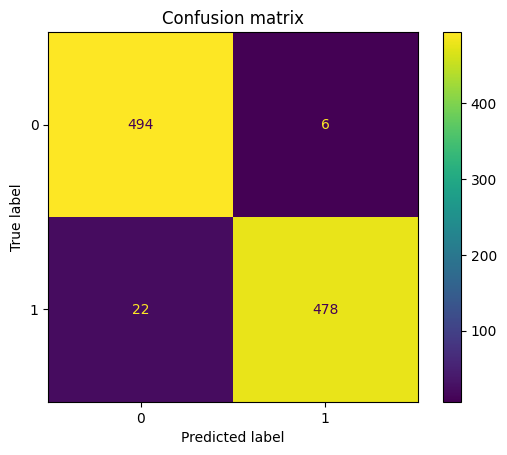

Accuracy Score on validation set: 97.20%


0.972

In [90]:
eval(model=model,
     val_loader=val_loader)

### Manual L2 norm

In [109]:
from torchvision.models import AlexNet_Weights

#model = torch.hub.load('pytorch/vision:v0.10.0', model='alexnet', weights=AlexNet_Weights.DEFAULT)
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_v0.10.0


In [110]:
NUM_EPOCHS = 5
losses = []

train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      criterion=loss_fn,
      epochs=NUM_EPOCHS,
      regularization='l2',
      reg_lambda=1e-3)

400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 4537.8125
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 2: Loss = 4510.24169921875
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 3: Loss = 4497.12939453125
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 4: Loss = 4485.7763671875
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 5: Loss = 4475.74755859375


[tensor(4537.8125),
 tensor(4510.2417),
 tensor(4497.1294),
 tensor(4485.7764),
 tensor(4475.7476)]

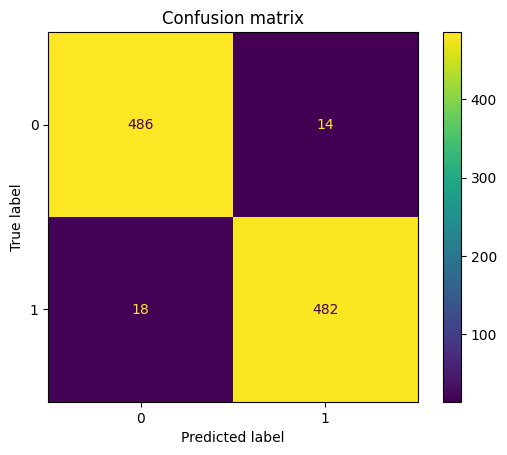

Accuracy Score on validation set: 96.80%


0.968

In [111]:
eval(model=model,
     val_loader=val_loader)

## Question - 2

### Manual L1 norm

In [107]:
from torchvision.models import AlexNet_Weights

#model = torch.hub.load('pytorch/vision:v0.10.0', model='alexnet', weights=AlexNet_Weights.DEFAULT)
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_v0.10.0
/home/student/Documents/220962262/DL_lab/dl_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/Documents/220962262/DL_lab/dl_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
Epoch 1: Loss = 240125.15625
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
Epoch 2: Loss = 226448.84375
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
Epoch 3: Loss = 213374.4375
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
Epoch 4: Loss = 200886.890625
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
Epoch 5: Loss = 188977.515625


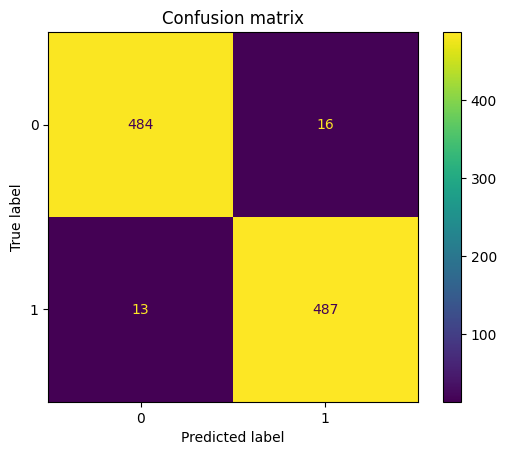

Accuracy Score on validation set: 97.10%


0.971

In [106]:
NUM_EPOCHS = 5
losses = []

train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      criterion=loss_fn,
      epochs=NUM_EPOCHS,
      regularization='l1',
      reg_lambda=1e-3)

eval(model=model,
     val_loader=val_loader)

## Question - 3

In [114]:
class DropoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3)
        self.pool = nn.MaxPool2d((2, 2), stride=2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(16*12*12, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = self.relu(self.pool(self.conv4(x)))
        x = self.drop(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x
    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3)
        self.pool = nn.MaxPool2d((2, 2), stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16*12*12, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = self.relu(self.pool(self.conv4(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x

### Training with Dropout

In [113]:
NUM_EPOCHS = 10

model = DropoutNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      criterion=criterion,
      epochs=NUM_EPOCHS,
      losses=[])

400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 345.3620910644531
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 2: Loss = 332.9461364746094
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 3: Loss = 316.3793640136719
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 4: Loss = 302.6006164550781
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 5: Loss = 288.99755859375
400 / 2000 : Progress = 20.00%
800 / 

[tensor(345.3621),
 tensor(332.9461),
 tensor(316.3794),
 tensor(302.6006),
 tensor(288.9976),
 tensor(279.6596),
 tensor(269.3118),
 tensor(261.7065),
 tensor(254.3150),
 tensor(247.1234)]

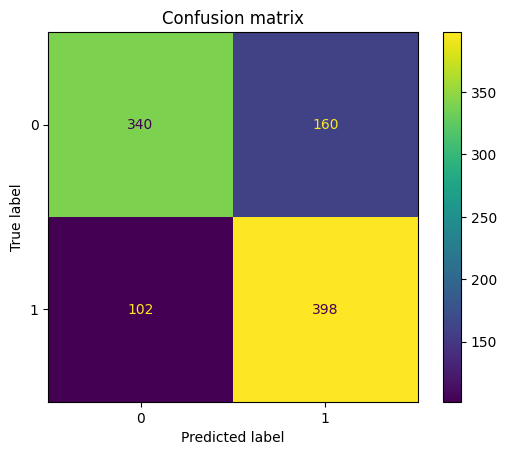

Accuracy Score on validation set: 73.80%


0.738

In [115]:
eval(model=model,
     val_loader=val_loader)

### Training without dropout

In [122]:
NUM_EPOCHS = 3

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      criterion=criterion,
      epochs=NUM_EPOCHS,
      losses=[])

400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 345.35882568359375
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 2: Loss = 333.0090637207031
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 3: Loss = 315.3018798828125


[tensor(345.3588), tensor(333.0091), tensor(315.3019)]

In [124]:
NUM_EPOCHS = 17

train(model=model,
      train_loader=train_loader,
      optimizer=optimizer,
      criterion=criterion,
      epochs=NUM_EPOCHS,
      losses=[])

400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 300.15301513671875
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 2: Loss = 288.0472106933594
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 3: Loss = 275.5261535644531
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 4: Loss = 267.97509765625
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 5: Loss = 258.7720947265625
400 / 2000 : Progress = 20.00%
800 /

[tensor(300.1530),
 tensor(288.0472),
 tensor(275.5262),
 tensor(267.9751),
 tensor(258.7721),
 tensor(248.5467),
 tensor(242.3762),
 tensor(235.8575),
 tensor(227.1138),
 tensor(222.0070),
 tensor(213.5230),
 tensor(209.2952),
 tensor(203.2740),
 tensor(200.3914),
 tensor(196.3610),
 tensor(195.0902),
 tensor(194.1948)]

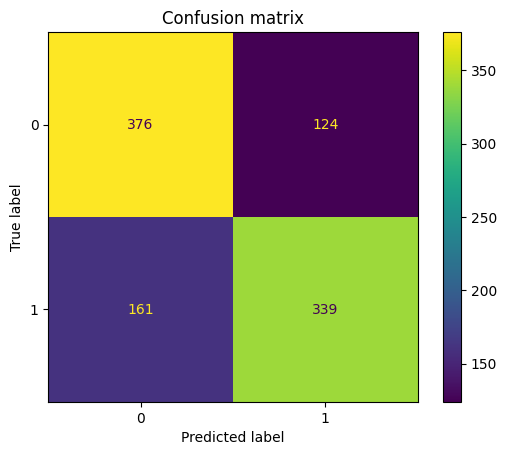

Accuracy Score on validation set: 71.50%


0.715

In [126]:
eval(model=model,
     val_loader=val_loader)

## Question - 5

### Early Stopping

In [134]:
from torchvision.models import AlexNet_Weights

#model = torch.hub.load('pytorch/vision:v0.10.0', model='alexnet', weights=AlexNet_Weights.DEFAULT)
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

NUM_EPOCHS = 10

# Define early stopping parameters
patience = 5
best_validation_loss = float('inf')
best_validation_acc = 0.0
current_patience = 0

# Training loop
for epoch in range(1, NUM_EPOCHS+1):
    print(f"Epoch {epoch}:")
    train(model=model,
          train_loader=train_loader,
          optimizer=optimizer,
          criterion=criterion,
          epochs=1,
          losses=[])
    
    # Validation step
    validation_acc, validation_loss = eval(model=model,
                         val_loader=val_loader,
                         criterion=criterion,
                         print_conf=False
                        )
    
    printf(f"Current validation loss: {validation_loss}, validation accuracy: {validation_acc:.2%}")

    # Check for improvement in validation loss
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        best_validation_acc = validation_acc
        current_patience = 0

        # Save the model if desired
        torch.save(model.state_dict(), './Models/best_model.pth')
    
    else:
        current_patience += 1
        
    # Check if early stopping criteria are met
    if current_patience > patience:
        print("Early stopping! No improvement for {} epochs.".format(patience))
        break

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_v0.10.0
/home/student/Documents/220962262/DL_lab/dl_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/Documents/220962262/DL_lab/dl_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 196.6525421142578
Accuracy Score on validation set: 95.80%
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 177.33807373046875
Accuracy Score on validation set: 95.80%
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 173.30453491210938
Accuracy Score on validation set: 96.10%
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%
1200 / 2000 : Progress = 60.00%
1600 / 2000 : Progress = 80.00%
2000 / 2000 : Progress = 100.00%
Epoch 1: Loss = 168.92005920410156
Accuracy Score on validation set: 96.30%
400 / 2000 : Progress = 20.00%
800 / 2000 : Progress = 40.00%

In [137]:
print(f"Best validation loss with early stopiping algorithm: {best_validation_loss}")
print(f"Best validation accuracy with early stopiping algorithm: {best_validation_acc:.2%}")

Best validation loss with early stopiping algorithm: 85.78315323591232
Best validation accuracy with early stopiping algorithm: 96.90%
